In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time_series.time_series_models import KernelRidgeRegression
from time_series.kernels import GaussianKernel

2025-11-17 12:09:44.533 | INFO     | time_series.config:<module>:13 - PROJ_ROOT path is: /home/james/Repo/PhD Repo/time_series_clustering


In [2]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator
from sklearn.metrics import silhouette_score, rand_score, adjusted_rand_score
from sklearn.cluster import KMeans

In [3]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

In [4]:
import itertools
import tqdm

In [5]:
class DataHolder:
    def __init__(self, **kwargs):
        self.update(**kwargs)
    
    def update(self, **kwargs):
        self.__dict__.update(kwargs)

In [6]:
class GridSearch:
    def __init__(self, estimator, param_grid, scoring=None, nfolds=5):
        self.estimator = estimator
        self.param_grid = param_grid
        self.scoring = scoring if scoring else mean_squared_error
        self.nfolds = nfolds
    
    def fit(self, X, y=None):
        param_names = list(self.param_grid.keys())
        param_values = list(itertools.product(*self.param_grid.values()))

        result = []

        best_score = np.inf
        best_params = []
        
        for p in param_values:
            mapping = {param_names[i]:p[i] for i in range(len(param_names))}
            model = self.estimator(**mapping)

            kf = KFold(n_splits=self.nfolds, random_state=None, shuffle=False)
            scores = []
            
            for i, (train_index, test_index) in enumerate(kf.split(X)):
                X_train = X[train_index]
                X_test = X[test_index]

                y_train = y[train_index]
                y_test = y[test_index] 

                model.fit(X_train, y_train)

                y_pred = model.predict(X_test)

                score = self.scoring(y_test, y_pred)
                scores.append(score)
            
            cv_score = np.mean(scores)
            result.append(
                (mapping, cv_score)
            )

            if cv_score < best_score:
                best_score = cv_score
                best_params = p
        
        self.best_score = best_score
        self.best_params = best_params

        self.cv_results = result


In [7]:
class KRRWrapper(BaseEstimator):
    def __init__(self, bandwidth, reg):
        self.model = KernelRidgeRegression(
            kernels=[GaussianKernel(bandwidth=bandwidth)],
            reg = reg
        )

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

In [104]:
def generate_time_series(x0:list, f, N=200, epsilon=0):
    x = np.zeros(shape=(N))
    for i in range(len(x0)):
        x[i] = x0[i]

    for i in range(len(x0), N):
        x[i] = f(x[:i]) + np.random.normal(0, epsilon)

    return x

In [128]:
epsilon = 1
n_sets = 1
x0 = [1.5, 1.5]
lag = 1

parameters = dict(
    k1 = 5,
    c1 = 0, 
    dt1 = 0.1,

    k2 = 5,
    c2 = 0.2,
    dt2 = 0.1,

    k3 = 5,
    c3 = -0.2,
    dt3 = 0.1
)

dynamics = [
    # lambda x: 2*x[-1] - x[-2] + parameters["dt1"]**2 * (-parameters["k1"]*x[-1] - parameters["c1"]*(x[-1] - x[-2])/parameters["dt1"]),
    # lambda x: 2*x[-1] - x[-2] + parameters["dt2"]**2 * (-parameters["k2"]*x[-1] - parameters["c2"]*(x[-1] - x[-2])/parameters["dt2"]),
    # lambda x: 2*x[-1] - x[-2] + parameters["dt3"]**2 * (-parameters["k3"]*x[-1] - parameters["c3"]*(x[-1] - x[-2])/parameters["dt3"]),

    lambda x: np.exp(-(x[-1]-1)**2),
    lambda x: np.exp(-(x[-1]+1)**2),
    lambda x: np.exp(-(x[-1])**2),

    lambda x: np.sin(x[-1])  
]

In [139]:
# epsilon = 0
# n_sets = 10
# x0 = [1.5, 1.5]

# lag = 2

# k1 = 5
# c1 = 0
# dt1 = 0.1
# f1 = lambda x: 2*x[-1] - x[-2] + dt1**2 * (-k1*x[-1] - c1*(x[-1] - x[-2])/dt1)+ np.random.normal(0, epsilon)

# k2 = 5
# c2 = 0.2
# dt2 = 0.1
# f2 = lambda x: 2*x[-1] - x[-2] + dt2**2 * (-k2*x[-1] - c2*(x[-1] - x[-2])/dt2)+ np.random.normal(0, epsilon)


# k3 = 5
# c3 = -0.2
# dt3 = 0.1
# f3 = lambda x: 2*x[-1] - x[-2] + dt3**2 * (-k3*x[-1] - c3*(x[-1] - x[-2])/dt3)+ np.random.normal(0, epsilon)

# # dynamics = [f1, f3]

# # f1 = lambda x: np.exp(-(x[-1]-1)**2) + np.random.normal(0, epsilon)
# # f2 = lambda x: np.exp(-(x[-1]+1)**2) + np.random.normal(0, epsilon)
# # f3 = lambda x: np.exp(-(x[-1])**2) + np.random.normal(0, epsilon)

# dynamics = [f1, f2, f3]

datasets = []

for d_id, fd in enumerate(dynamics):
    for i in range(n_sets):
        #np.random.random()
        d = generate_time_series(x0, fd, 300, epsilon=epsilon)
        datasets.append(
            DataHolder(
                data=d,
                label=d_id
            )
        )

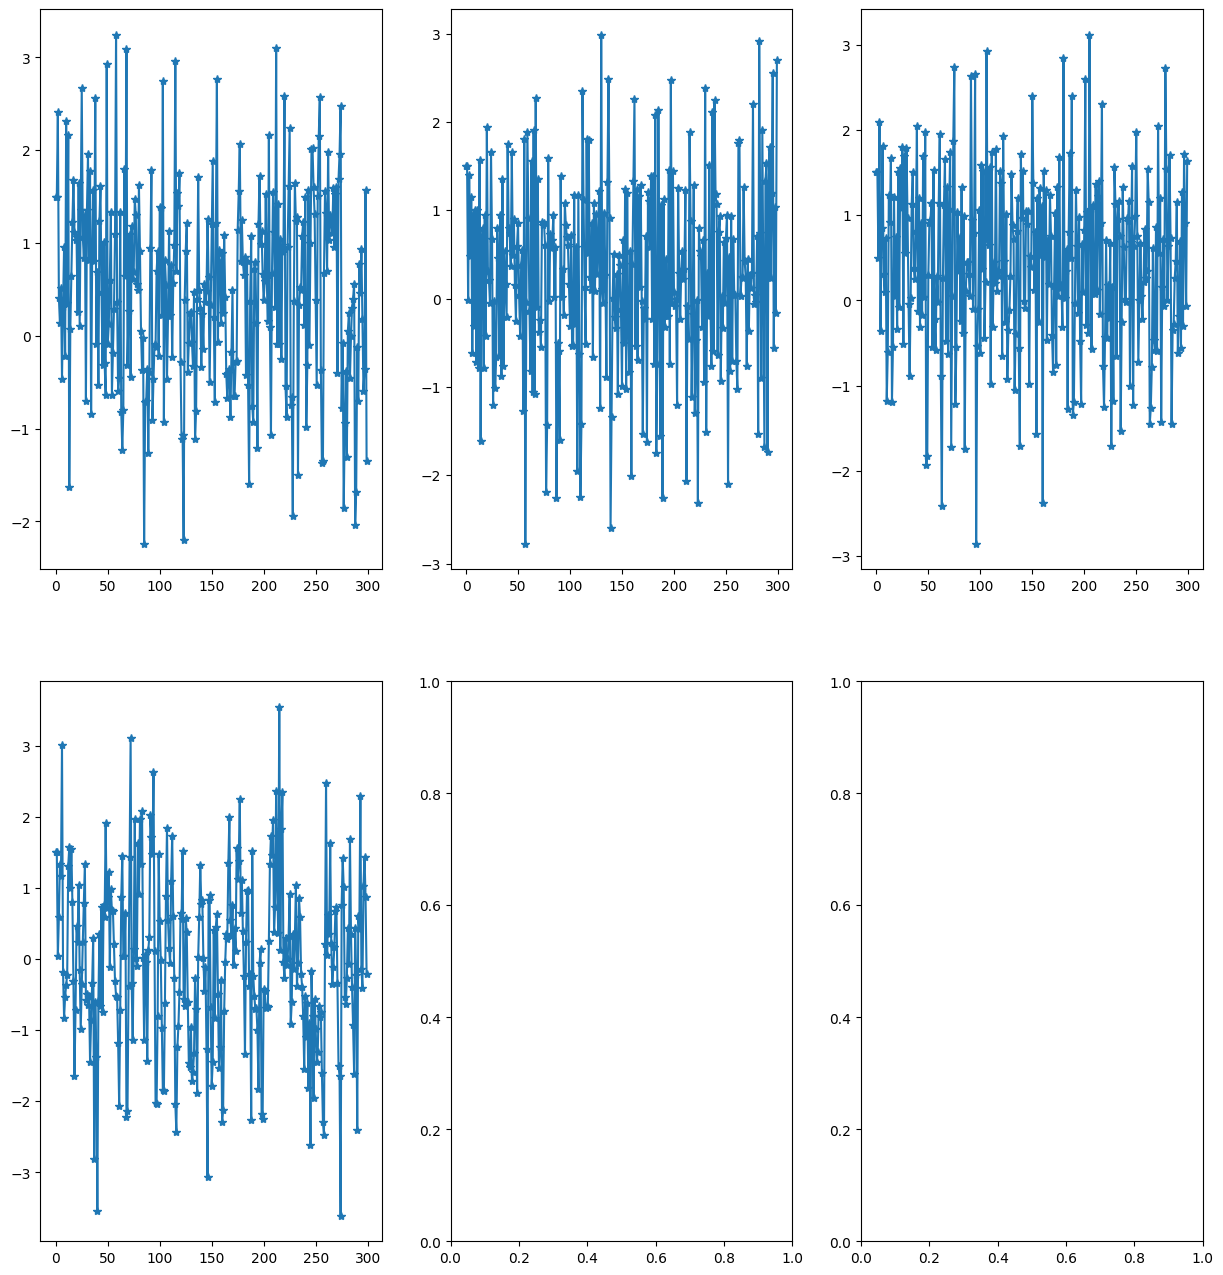

In [140]:
ncols = 3
nrows = int(np.ceil(len(dynamics)/3))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 16))

for i in range(len(datasets)):
    row = i//ncols
    col = i%ncols

    ax[row][col].plot(np.arange(len(datasets[i].data)), datasets[i].data, "-*")

In [141]:
gridsearch = GridSearch(
    KRRWrapper,
    param_grid={
        "bandwidth": np.linspace(0.1, 2, 20),
        "reg": 1/10**np.linspace(1, 12, 20)
    },
    scoring=mean_squared_error
)

In [142]:
for d in tqdm.tqdm(datasets):
    # N = len(d.data) - 1
    # x_train, y_train, x_test, y_test = d.data[:-1][:N//2], d.data[1:][:N//2], d.data[:-1][N//2:], d.data[1:][N//2:]
    x_train, y_train = d.data[:-1], d.data[1:]

    gridsearch.fit(x_train, y_train)
    bandwidth, reg = gridsearch.best_params

    model = KernelRidgeRegression(
        kernels=[GaussianKernel(bandwidth=bandwidth)],
        reg = reg,
        lag=lag
    )

    model.fit(x_train)

    # print(mean_squared_error(model.predict(x_test), y_test[1:]))
    
    d.update(
        bandwidth=bandwidth,
        model=model,
        kernel=model.kernels[0],
        alpha=model.alpha
    )

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:45<00:00, 11.26s/it]


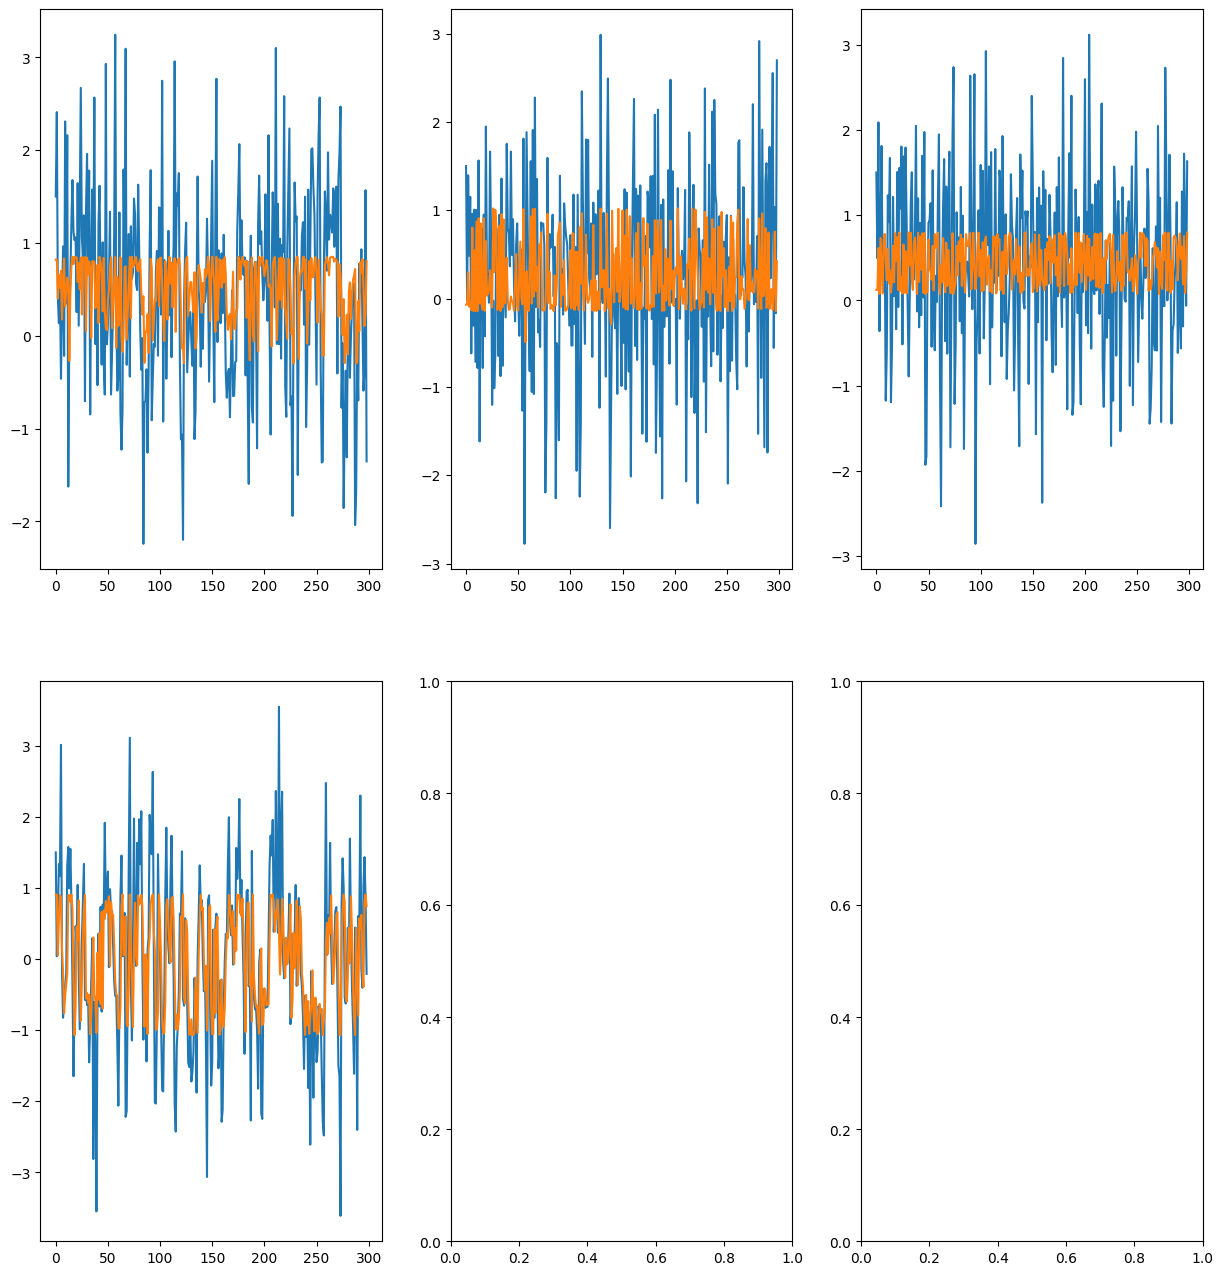

In [143]:
ncols = 3
nrows = int(np.ceil(len(dynamics)/3))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 16))

for i in range(len(datasets)):
    row = i//ncols
    col = i%ncols

    ax[row][col].plot(datasets[i].data[lag:])
    ax[row][col].plot(datasets[i].model.predict(datasets[i].data[:-1]))


In [151]:
xaxis.shape

(100,)

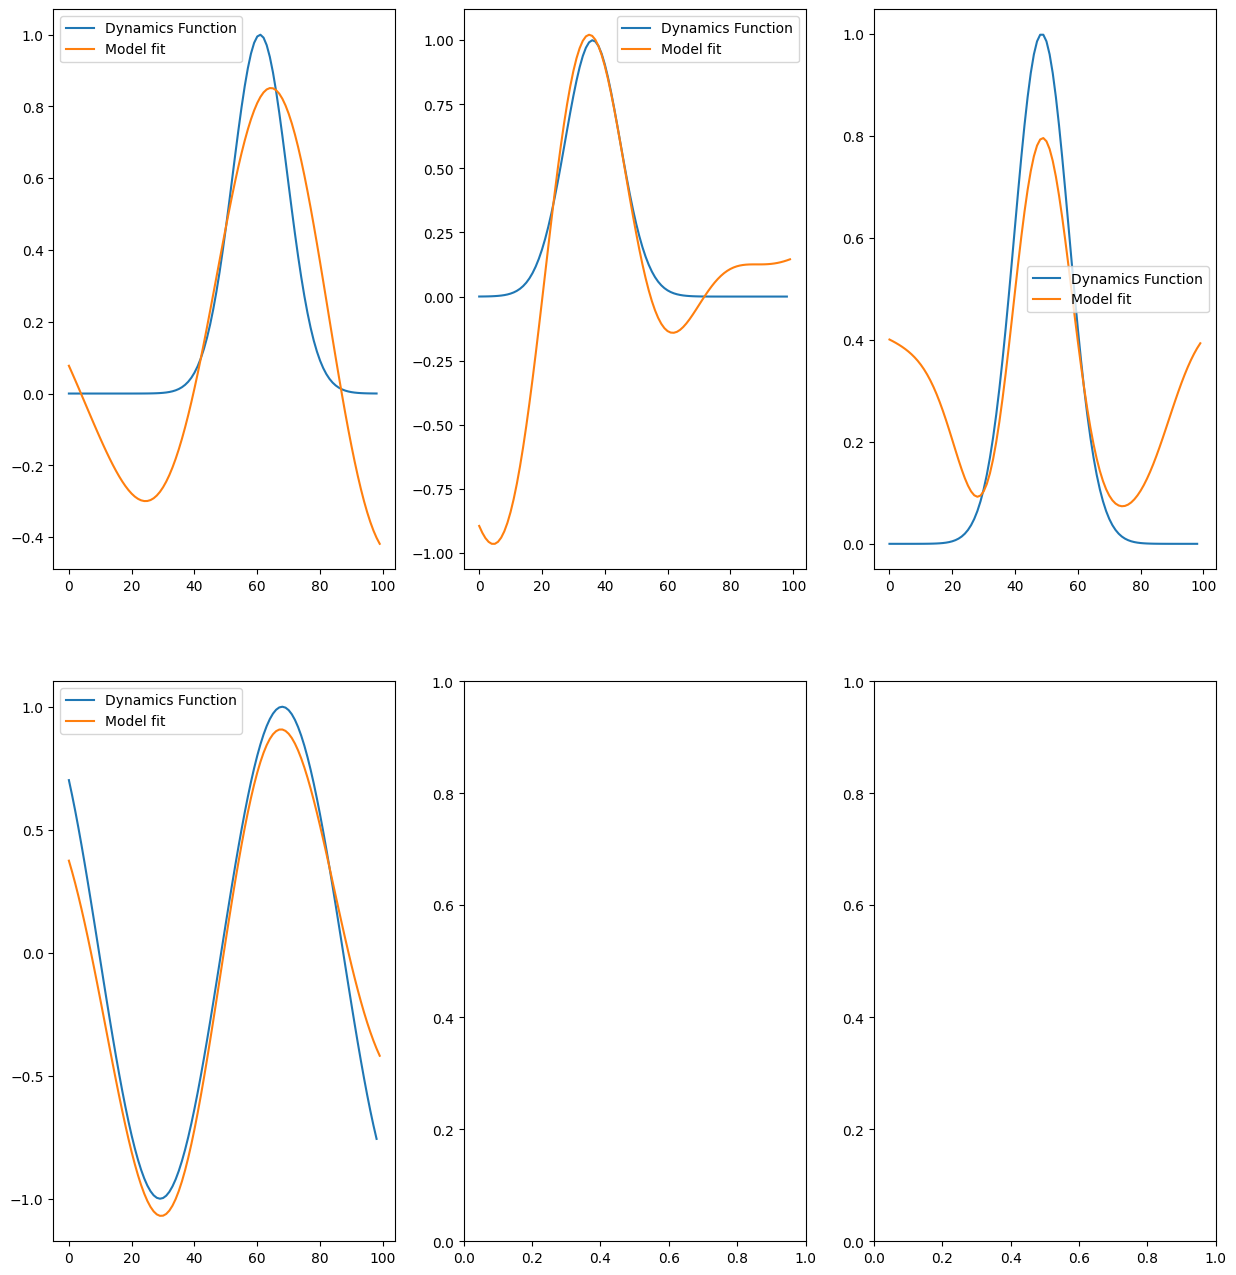

In [154]:
# Recover dynamics
x = np.linspace(-4, 4, 100)

ncols = 3
nrows = int(np.ceil(len(dynamics)/3))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 16))

for n in range(len(datasets)):
    row = n//ncols
    col = n%ncols

    # xaxis = np.linspace(datasets[n].data.min(), datasets[n].data.max(), 100)

    ax[row][col].plot([dynamics[n](x[i-1:i+1]) for i in range(1, len(x))])
    ax[row][col].plot(datasets[n].model.predict(x))
    ax[row][col].legend(["Dynamics Function", "Model fit"])

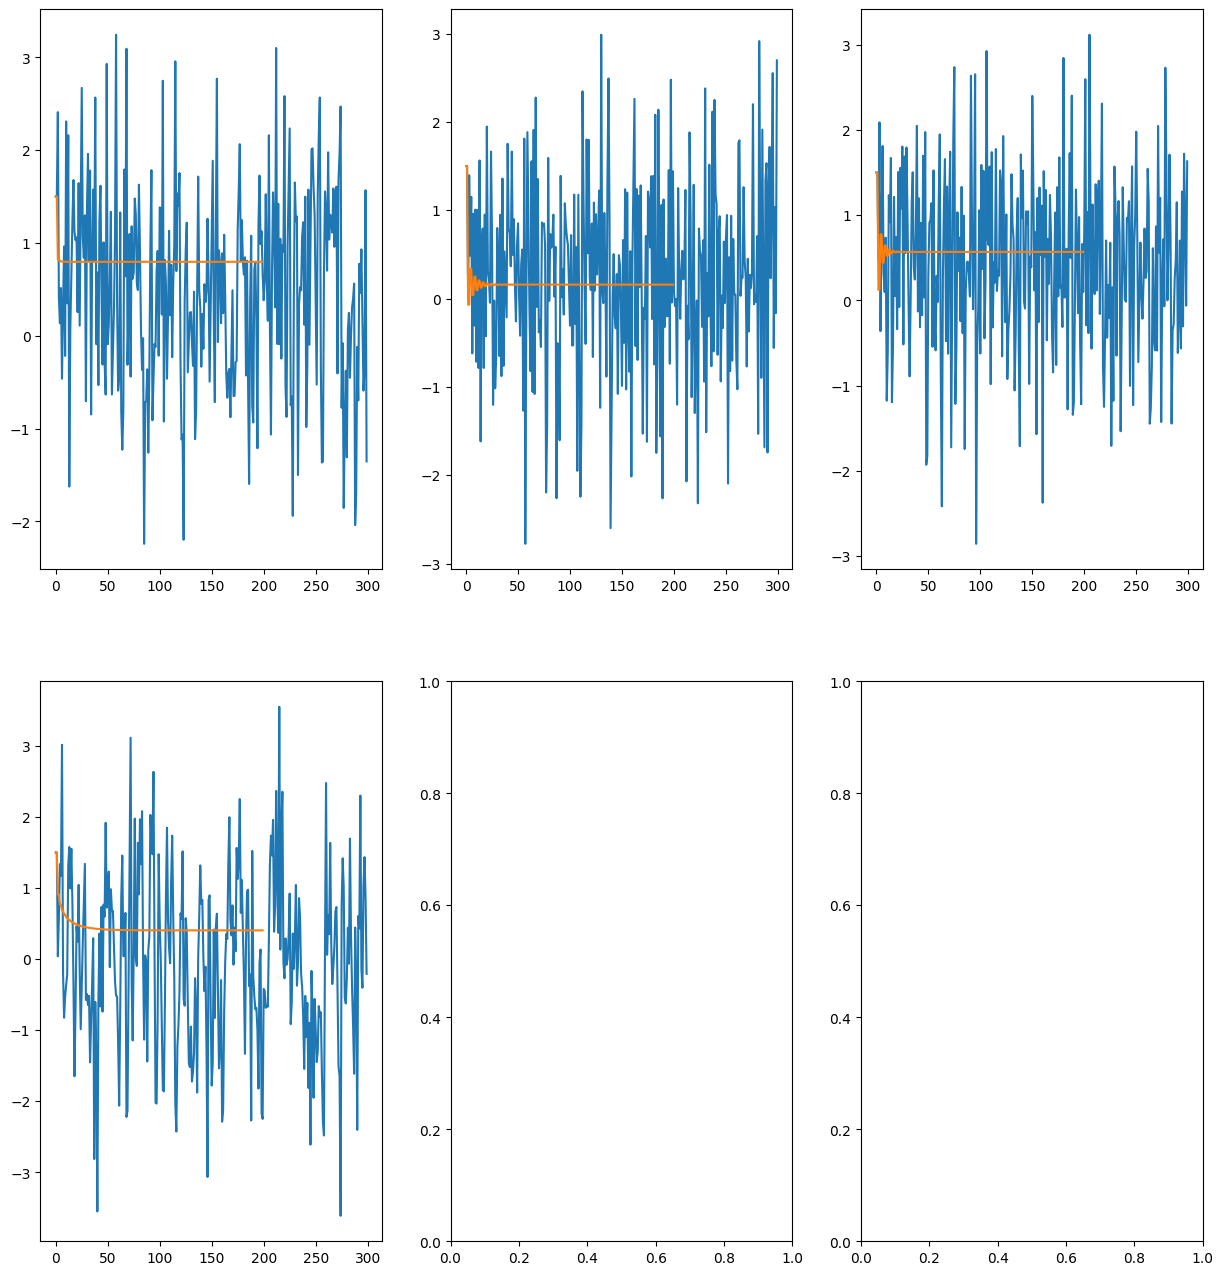

In [145]:
forcast = lambda model: lambda x: model.predict(np.array(x[-2:])).flatten()[0]

ncols = 3
nrows = int(np.ceil(len(dynamics)/3))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 16))

for n in range(len(datasets)):
    row = n//ncols
    col = n%ncols

    ax[row][col].plot(datasets[n].data)
    ax[row][col].plot(generate_time_series(datasets[n].data[:2], forcast(datasets[n].model), 200))


In [ ]:
# Clustering
similarity_matrix = np.zeros((len(datasets), len(datasets)))
distance_matrix = np.zeros((len(datasets), len(datasets)))

kernel = GaussianKernel(bandwidth=1)

for i in range(len(datasets)):
    dii = (datasets[i].alpha.T@kernel(datasets[i].data[:-lag-1]/datasets[i].bandwidth, datasets[i].data[:-lag-1]/datasets[i].bandwidth)@datasets[i].alpha)[0][0]
    for j in range(i, len(datasets)):
        djj = (datasets[j].alpha.T@kernel(datasets[j].data[:-lag-1]/datasets[j].bandwidth, datasets[j].data[:-lag-1]/datasets[j].bandwidth)@datasets[j].alpha)[0][0]

        dij = (datasets[i].alpha.T@kernel(datasets[i].data[:-lag-1]/datasets[i].bandwidth, datasets[j].data[:-lag-1]/datasets[j].bandwidth)@datasets[j].alpha)[0][0]

        similarity_matrix[i][j] = dij
        distance_matrix[i][j] = dii + djj - 2*dij
        # similarity_matrix[i][j] = dij/np.sqrt(dii*djj) # Cosine distance
        similarity_matrix[j][i] = similarity_matrix[i][j]
        distance_matrix[j][i] = distance_matrix[i][j]


# distance_matrix[distance_matrix < 0] = 0

# # Assuming D is your full distance matrix
# condensed_D = squareform(distance_matrix)  # if D is a full matrix
# Z = linkage(condensed_D, method='average')
# labels = fcluster(Z, t=len(dynamics), criterion='maxclust')  # t is number of clusters

# adjusted_rand_score(
#     labels_true=[d.label for d in datasets],
#     labels_pred=labels+ self.y_mean
# ), rand_score(
#     labels_true=[d.label for d in datasets],
#     labels_pred=labels  
# )

$$
\frac{1}{N} \sum_i (f(x_i) - \hat{f}(x_i))^2
$$

$$
\frac{1}{N} \sum_i (x_{i+1} - \hat{f}(\frac{(x_i -\bar{x})}{\sigma_x}))^2
$$

$$
y = f(x)\\


y - \hat{f}(\frac{x - \bar{x}}{\sigma_x})
$$

$$
\beta = (K(X, X) - \lambda I)^{-1} K(X, X) y
$$

$$
\beta = (K(X, X) - \lambda I)^{-1} K(X, X) (y - \bar{y})\\
\hat{f}(x) = K(x, X) \beta + \bar{y}
$$

$$
E_{\pi}(X) = 0\\
Var_{\pi}(X) = 1
$$

$$
K(\|x - x^\prime\|)
$$

Assume {X_t} are centered. The original, uncentered data are {Z_t}. Train \hat{f} only on {X_t}.

Calculate \hat{X_t} = \hat{f}(X_{t-1}).

Then, let \hat{Y_t} = \hat{X_t} +  \bar{X}_t.

Compare: (\hat{Y}_t - f(Z_t))^2, where f is the true, non-centered regression function

In [139]:
# Graph laplacian
D = np.diag(similarity_matrix.sum(axis=0))

L = D - similarity_matrix

evals, evecs = np.linalg.eig(L)
eval_idx = np.argsort(evals)

evals = evals[eval_idx]
evecs = evecs[:, eval_idx]

kmeans = KMeans(n_clusters=3)
elbow_idx = (np.where(evals[1:] - evals[:-1] > 1e-6)[0] + 1)[1] # Find the first instance where the increase in eval size is less than 1e-6. Call this the elbow
labels = kmeans.fit_predict(np.abs(evecs[:, :elbow_idx]))

cluster_labels = pd.Series(labels)

for c in cluster_labels.unique():
    cluster_indices = cluster_labels[cluster_labels == c].index
    cluster_truth_labels = [datasets[i].label for i in cluster_indices]

    print(f"{c}: {cluster_truth_labels}")

print(adjusted_rand_score(
    labels_true=[d.label for d in datasets],
    labels_pred=labels
), rand_score(
    labels_true=[d.label for d in datasets],
    labels_pred=labels  
))

0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
1: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
1.0 1.0


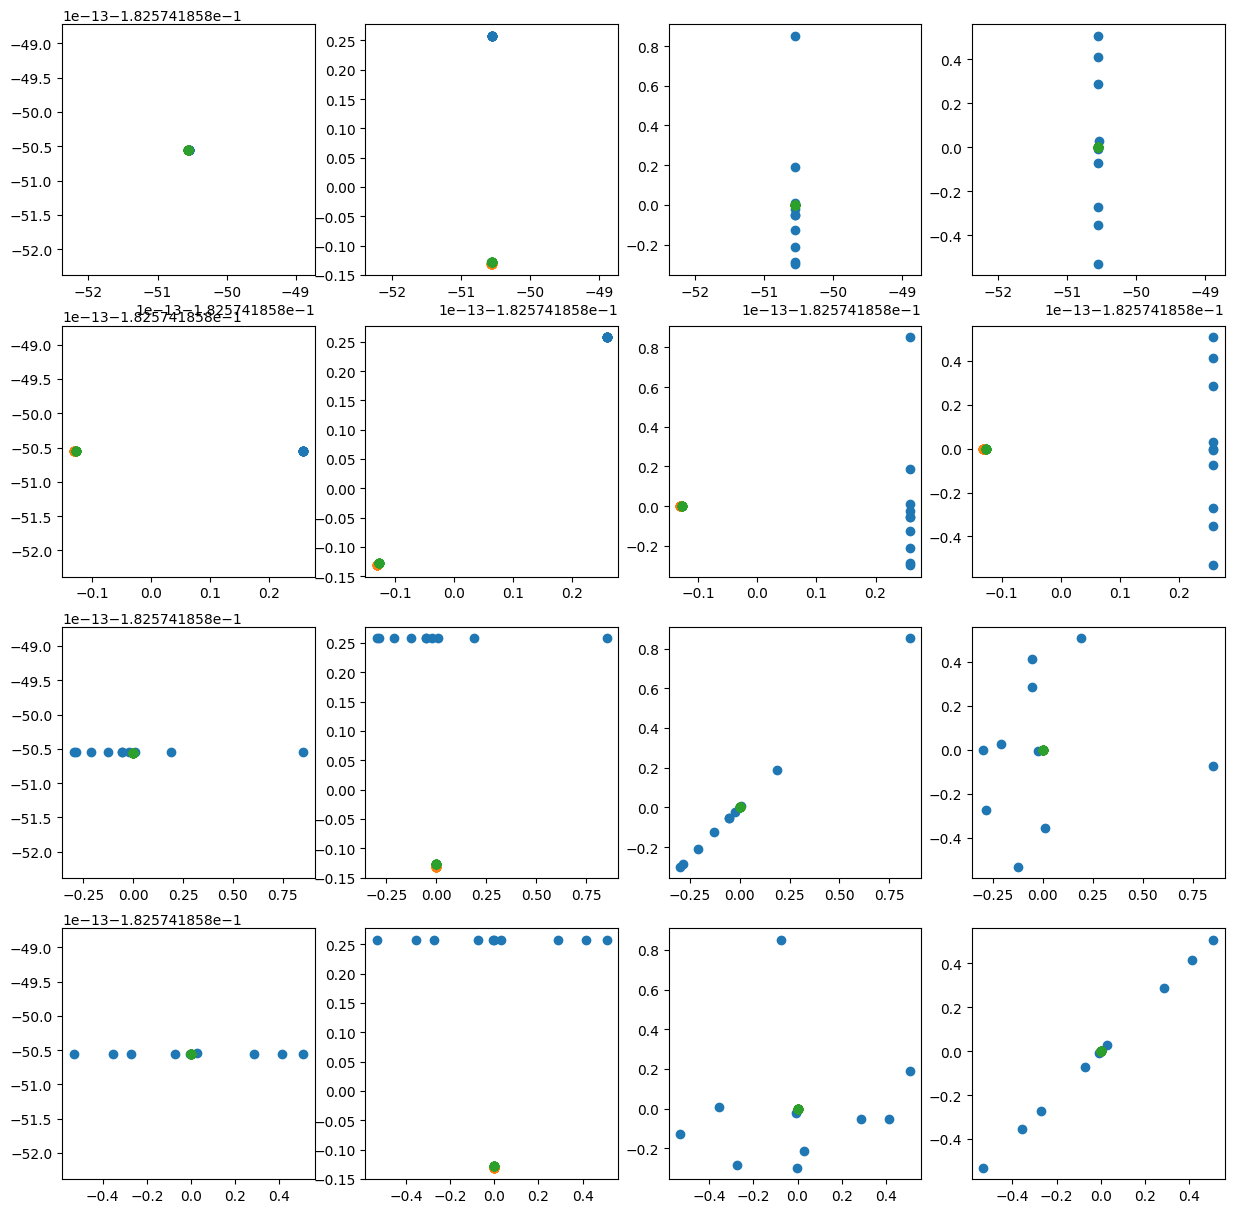

In [140]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

for i in range(4):
    for j in range(4):
        ax[i, j].scatter(evecs[  :10, i], evecs[  :10, j])
        ax[i, j].scatter(evecs[10:20, i], evecs[10:20, j])
        ax[i, j].scatter(evecs[20:30, i], evecs[20:30, j])

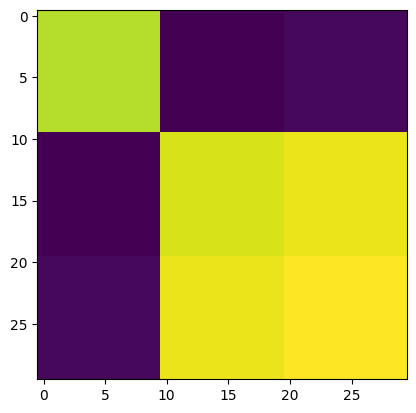

In [141]:
plt.imshow(similarity_matrix)

In [142]:
# distance_matrix[distance_matrix < 0] = 0

# Assuming D is your full distance matrix
condensed_D = squareform(distance_matrix)  # if D is a full matrix
Z = linkage(condensed_D, method='average')
labels = fcluster(Z, t=len(dynamics), criterion='maxclust')  # t is number of clusters

cluster_labels = pd.Series(labels)

for c in cluster_labels.unique():
    cluster_indices = cluster_labels[cluster_labels == c].index
    cluster_truth_labels = [datasets[i].label for i in cluster_indices]

    print(f"{c}: {cluster_truth_labels}")

adjusted_rand_score(
    labels_true=[d.label for d in datasets],
    labels_pred=labels
), rand_score(
    labels_true=[d.label for d in datasets],
    labels_pred=labels  
)

1: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
3: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


(1.0, 1.0)

# Repeated

In [88]:
# epsilon = 1e-2
# n_sets = 10

# f1 = lambda x: np.exp(-(x-1)**2) + np.random.normal(0, epsilon)
# f2 = lambda x: np.exp(-(x+1)**2) + np.random.normal(0, epsilon)
# f3 = lambda x: np.exp(-(x)**2) + np.random.normal(0, epsilon)

# dynamics = [f1, f2, f3]

In [158]:
epsilon = 1e-3
n_sets = 10
x0 = [1.5, 1.5]

lag = 2

f1 = lambda x: -0.1*x[-1] + 2*x[-1] - x[-2] + np.random.normal(0, epsilon)
# f2 = lambda x: -0.02*x[-2] + 2*x[-1] - x[-2] + np.random.normal(0, epsilon)

k1 = 5
c1 = 0.2
dt = 0.1
f2 = lambda x: 2*x[-1] - x[-2] + dt**2 * (-k1*x[-1] - c1*(x[-1] - x[-2])/dt)+ np.random.normal(0, epsilon)


k2 = 5
c2 = -0.2
dt = 0.1
f3 = lambda x: 2*x[-1] - x[-2] + dt**2 * (-k2*x[-1] - c2*(x[-1] - x[-2])/dt)+ np.random.normal(0, epsilon)

In [ ]:
gridsearch = GridSearch(
    KRRWrapper,
    param_grid={
        "bandwidth": np.linspace(0.1, 4, 40),
        "reg": 1/10**np.linspace(1, 12, 20)
    },
    scoring=mean_squared_error
)

In [160]:
results = dict(
    rand_score = [],
    adj_rand_score = []
)


In [164]:
# Loop
for i in tqdm.tqdm(range(50)):
    datasets = []

    for d_id, fd in enumerate(dynamics):
        for i in range(n_sets):
            # x0 = np.random.random()
            d = generate_time_series(x0, fd, 400)
            datasets.append(
                DataHolder(
                    data=d,#(d - d.min())/(d.max()- d.min()),
                    label=d_id
                )
            )

    for d in datasets:
        gridsearch.fit(d.data[:-1], d.data[1:])
        bandwidth, reg = gridsearch.best_params

        model = KernelRidgeRegression(
            kernels=[GaussianKernel(bandwidth=bandwidth)],
            reg = reg
        )

        model.fit(d.data)
        
        d.update(
            bandwidth=bandwidth,
            model=model,
            kernel=model.kernels[0],
            alpha=model.alpha
        )

    # Clustering
    similarity_matrix = np.zeros((len(datasets), len(datasets)))
    distance_matrix = np.zeros((len(datasets), len(datasets)))

    kernel = GaussianKernel(bandwidth=1)

    for i in range(len(datasets)):
        dii = (datasets[i].alpha.T@kernel(datasets[i].data[:-1]/datasets[i].bandwidth, datasets[i].data[:-1]/datasets[i].bandwidth)@datasets[i].alpha)[0][0]
        for j in range(i, len(datasets)):
            djj = (datasets[j].alpha.T@kernel(datasets[j].data[:-1]/datasets[j].bandwidth, datasets[j].data[:-1]/datasets[j].bandwidth)@datasets[j].alpha)[0][0]

            dij = (datasets[i].alpha.T@kernel(datasets[i].data[:-1]/datasets[i].bandwidth, datasets[j].data[:-1]/datasets[j].bandwidth)@datasets[j].alpha)[0][0]

            similarity_matrix[i][j] = dij
            distance_matrix[i][j] = dii + djj - 2*dij
            # similarity_matrix[i][j] = dij/np.sqrt(dii*djj) # Cosine distance
            similarity_matrix[j][i] = similarity_matrix[i][j]
            distance_matrix[j][i] = distance_matrix[i][j]

    # Graph laplacian
    D = np.diag(similarity_matrix.sum(axis=0))

    L = D - similarity_matrix

    evals, evecs = np.linalg.eig(L)
    eval_idx = np.argsort(evals)

    evals = evals[eval_idx]
    evecs = evecs[:, eval_idx]

    kmeans = KMeans(n_clusters=3)
    labels = kmeans.fit_predict(evecs[:, :4])

    results["rand_score"].append(rand_score(
        labels_true=[d.label for d in datasets],
        labels_pred=labels  
    ))

    results["adj_rand_score"].append(adjusted_rand_score(
        labels_true=[d.label for d in datasets],
        labels_pred=labels  
    ))

 80%|████████  | 40/50 [2:06:34<31:38, 189.87s/it]  


KeyboardInterrupt: 

In [165]:
np.mean(results["rand_score"])

np.float64(0.6174946425092538)

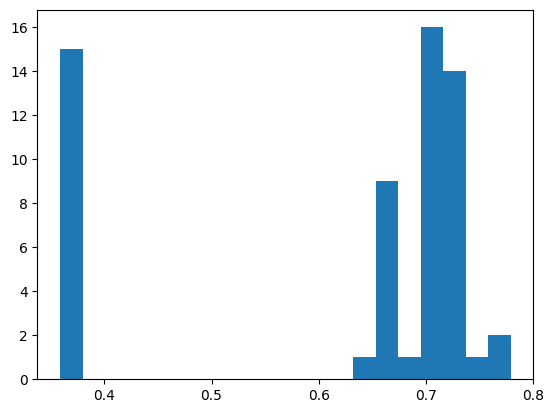

In [168]:
plt.hist(results["rand_score"], bins=20);